Imports and Reading Data

In [1]:
# libraries
import os, sys
import pandas as pd
import pickle
import re,string
import spacy,nltk
import sklearn,gensim,tweepy,pyLDAvis
from wordcloud import WordCloud

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [8]:
# reference source: https://medium.datadriveninvestor.com/trump-tweets-topic-modeling-using-latent-dirichlet-allocation-e4f93b90b6fe
df=pd.read_csv("../data/tweets_01-08-2021.csv")
# dropping the retweets
df=df.loc[df['isRetweet']=='f']
print(df.shape[0])
df.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
46694


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
6,1223640662689689602,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,f
7,1319501865625784320,https://t.co/4qwCKQOiOw,f,f,Twitter for iPhone,130822,19127,2020-10-23 04:52:14,f


In [5]:
tweets_df=df.loc[:,['text']]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46694 entries, 0 to 56570
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    46694 non-null  object
dtypes: object(1)
memory usage: 729.6+ KB
/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# quick glance at the text
a = 46600
for i in range(a,a+10):
    print(tweets_df.text[i])
    print()

To those in the Caravan, turnaround, we are not letting people into the United States illegally. Go back to your Country and if you want, apply for citizenship like millions of others are doing!

“Remarks by President Trump on a Year of Historic Progress and Action to Combat the Opioid Crisis” https://t.co/YBTzMSOozW https://t.co/njGYwHff4t

The New York Times has a new Fake Story that now the Russians and Chinese (glad they finally added China) are listening to all of my calls on cellphones. Except that I rarely use a cellphone, &amp, when I do it’s government authorized. I like Hard Lines. Just more made up Fake News!

A very big part of the Anger we see today in our society is caused by the purposely false and inaccurate reporting of the Mainstream Media that I refer to as Fake News. It has gotten so bad and hateful that it is beyond description. Mainstream Media must clean up its act, FAST!

Brandon Judd of the National Border Patrol Council is right when he says on @foxandfriends 

Data Cleaing -- Using code from Mark

In [11]:
# Data cleaning:
# Lowercase text
# Remove brackets using regular expressions
# remove punctuation and numbers using regular expressions

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\[.*?\]', '', text)
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub("https?://([^\s]+)", ' ', text) # links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    
    text = re.sub("rt", ' ', text) # RT : 
    text = re.sub(" &amp", ' ', text) # &amp
    text = re.sub("[\n\r\t\0]", ' ', text) # new line, tabs, etc
    text = re.sub('[!,.-;:\"“”\[\]{}]', ' ', text) # punct
    text = re.sub('\s{2,}', ' ', text) # 2+ whitespaces
   
    return text

tweets_df_clean = pd.DataFrame(tweets_df.text.apply(lambda x: clean_text(x)))


/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:12: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \s
<ipython-input-11-17f1bc126e7b>:12: DeprecationWarning: invalid escape sequence \s
  text = re.sub("https?://([^\s]+)", ' ', text) # links
<ipython-input-11-17f1bc126e7b>:18: DeprecationWarning: invalid escape sequence \[
  text = re.sub('[!,.-;:\"“”\[\]{}]', ' ', text) # punct
<ipython-input-11-17f1b

In [12]:
tweets_df_clean.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,republicans and democrats have both created ou...
1,i was thrilled to be back in the great city of...
3,the unsolicited mail in ballot scam is a major...
6,getting a little exercise this morning
7,


In [13]:
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet') ##################### need this line or will get error -- this line takes forever to run lol, should download the pack manually
import string

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Perform Lemmatization to reduce inflected words to their root words.----cannot run, my computer failed :(
# nlp = spacy.load("en_core_web_sm")
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     return " ".join(sent)

from nltk.corpus import wordnet

stop = set(stopwords.words('english'))
def lemmatizer(doc):
    lemma = WordNetLemmatizer()
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
    return normalized

tweets_df_clean = pd.DataFrame(tweets_df_clean.text.apply(lambda x: lemmatizer(x)))
tweets_df_clean['text'] = tweets_df_clean['text'].str.replace('-PRON-', '')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Easy EDAs

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


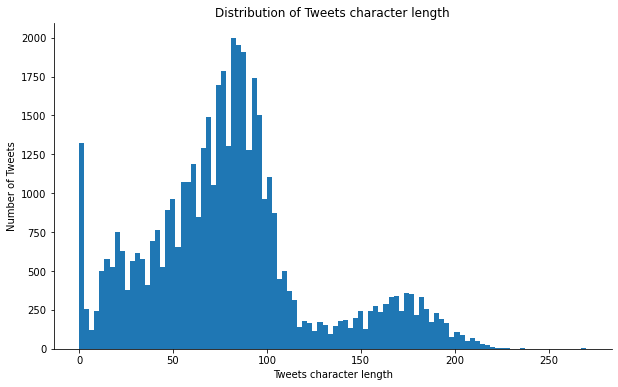

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


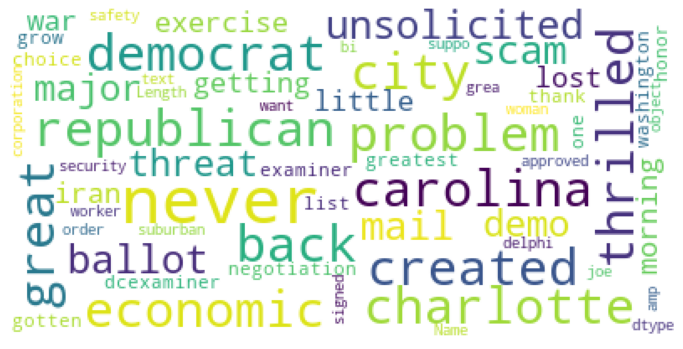

In [18]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Unigrams: remove all stop words to get unigrams

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(tweets_df_clean.text, 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unigram,count
0,realdonaldtrump,8405
1,great,7213
2,trump,6464
3,amp,4931
4,thank,3308
5,president,3206
6,people,3076
7,country,2547
8,new,2112
9,thanks,2086


Trigrams

In [21]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(tweets_df_clean.text, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigram

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,trigram,count
0,make america great,573
1,fake news medium,241
2,complete total endorsement,222
3,realdonaldtrump run president,171
4,happy bi hday,140
5,crooked hillary clinton,136
6,new york time,111
7,radical left democrat,108
8,think like champion,91
9,president united state,86


Topic modeling with LDA


In [22]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )

data_matrix = vectorizer.fit_transform(tweets_df_clean.text)
data_matrix

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<46694x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 397312 stored elements in Compressed Sparse Row format>

In [23]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_matrix)

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the buil

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  12.569676
6       0.648955  71.707100       2        1  11.653909
4      71.019684   9.971006       3        1  11.279280
7       3.785981  33.185135       4        1  10.778862
5     -42.666500  -9.222070       5        1  10.668410
0      -3.621689 -43.526516       6        1  10.431727
2      -3.632402  -4.171708       7        1   9.819503
9     -36.584400  35.804413       8        1   8.955605
1      44.391380  50.615383       9        1   7.330004
3      40.235809 -31.591665      10        1   6.513025, topic_info=                 Term         Freq        Total Category  logprob  loglift
3605  realdonaldtrump  7521.000000  7521.000000  Default  30.0000  30.0000
4595            trump  6232.000000  6232.000000  Default  29.0000  29.0000
1929            great  7144.000000  7144.000000  Default  28.0000  28.0000
4442            thank  3197.000000  3197.000000  Default  27.0000  27.0000
3432        president  3285.000000  3285.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
3975         security   566.637987   585.812211  Topic10  -3.8604   2.6981
2992         national   403.759963   673.887143  Topic10  -4.1993   2.2191
4834              war   196.843182   269.928799  Topic10  -4.9178   2.4156
2565       leadership   195.410117   290.613229  Topic10  -4.9251   2.3345
995           country   173.529342  2625.833751  Topic10  -5.0438   0.0146

[445 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
49        8  0.998098             act
52        4  0.998119          action
69        1  0.999079  administration
103      10  0.998581           agree
144       2  0.997828         allowed
...     ...       ...             ...
4979      7  0.724041            year
4981      4  0.994850             yes
4983      6  0.998668            york
4989      2  0.997493           youre
4996      2  0.994900            zero

[487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 5, 8, 6, 1, 3, 10, 2, 4])

In [25]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Top 10 words for topic #0:
['man', 'cnn', 'going', 'repo', 'medium', 'amp', 'trump', 'new', 'fake', 'news']


Top 10 words for topic #1:
['interview', 'enjoy', 'mexico', 'like', 'forward', 'way', 'foxandfriends', 'tonight', 'foxnews', 'look']


Top 10 words for topic #2:
['history', 'president', 'clinton', 'obama', 'true', 'deal', 'american', 'hillary', 'year', 'thanks']


Top 10 words for topic #3:
['agree', 'join', 'iran', 'national', 'john', 'illegal', 'friend', 'nation', 'security', 'congratulation']


Top 10 words for topic #4:
['working', 'time', 'country', 'today', 'love', 'china', 'run', 'great', 'thank', 'real

In [26]:
# get top 30 words in each topic and generate a csv file
df_topic=pd.DataFrame(columns=['Topic','TopWords'])
word_list=[]

for i,topic in enumerate(lda_model.components_):
    sub_list=[]
    print(f'Top 30 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')
    sub_list.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[-30:]])
    word_list.append(sub_list)

word_list

df_topic['Topic']=[1,2,3,4,5,6,7,8,9,10]
df_topic['TopWords']=word_list

df_topic.head()
df_topic.to_csv('../data/topic topics without RTs.csv',index=None)



/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Top 30 words for topic #0:
['watching', 'washington', 'isi', 'mueller', 'believe', 'rally', 'happen', 'justice', 'russia', 'fantastic', 'stop', 'fbi', 'collusion', 'dont', 'big', 'york', 'tomorrow', 'thing', 'totally', 'story', 'man', 'cnn', 'going', 'repo', 'medium', 'amp', 'trump', 'new', 'fake', 'news']


Top 30 words for topic #1:
['wow', 'politics', 'big', 'schiff', 'lie', 'pennsylvania', 'went', 'miss', 'voter', 'seanhannity', 'ohio', 'interviewed', 'crowd', 'little', 'wait', 'statement', 'rating', 'including', 'terrible', 'candidate', 'interview', 'enjoy', 'mexico', 'like', 'forward', 'way', 'foxandfriends', 'to

In [27]:
topic_values = lda_model.transform(data_matrix)
tweets_df['Topic'] = topic_values.argmax(axis=1)
tweets_df.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,Topic
0,Republicans and Democrats have both created ou...,8
1,I was thrilled to be back in the Great city of...,4
3,The Unsolicited Mail In Ballot Scam is a major...,7
6,Getting a little exercise this morning! https:...,5
7,https://t.co/4qwCKQOiOw,0


In [ ]:
# outputting the topic label and writing into a new csv file
